# Regression
#### author: "Masanao Yajima"
#### date: "2022-12-21"


In [1]:
knitr::opts_chunk$set(echo = TRUE,message=FALSE,fig.align="center",fig.width=7,fig.height=2.5)
pacman::p_load(
       car
      , ggplot2
      , ggExtra
      , reshape2
      , corrplot
      , RColorBrewer
      , lubridate
      , AmesHousing
      )

In [3]:
# Global paramter
show_code <- TRUE

# Class Workbook {.tabset .tabset-fade .tabset-pills}

## In class activity
### Ames Housing data

Please take a look at the Ames Hoursing data.

In [4]:
library(AmesHousing)
?ames_raw

The goal of this exercise is to predict the price of the house.

Here is a histogram of the sales price with red line showing the mean.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12789  129500  160000  180796  213500  755000 

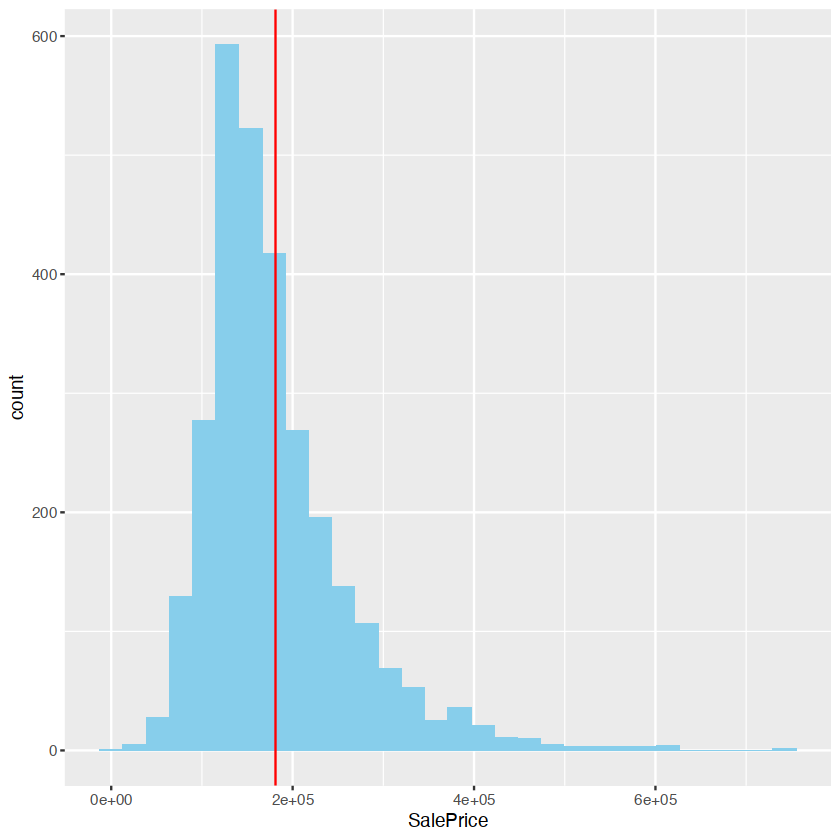

In [5]:
ggplot(ames_raw)+geom_histogram(fill="skyblue")+aes(x=SalePrice)+
  geom_vline(xintercept = mean(ames_raw$SalePrice),col="red")
summary(ames_raw$SalePrice)

Initial linear model without a predictor

In [6]:
lmfit_null<- lm(SalePrice~1,ames_raw)
summary(lmfit_null)


Call:
lm(formula = SalePrice ~ 1, data = ames_raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-168007  -51296  -20796   32704  574204 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   180796       1476   122.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 79890 on 2929 degrees of freedom


How good is this result?  Let's look at RMSE.

In [7]:
sqrt(mean(residuals(lmfit_null)^2))

[1] 79873.06

Since the price is right skewed lets log transformation the outcome

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


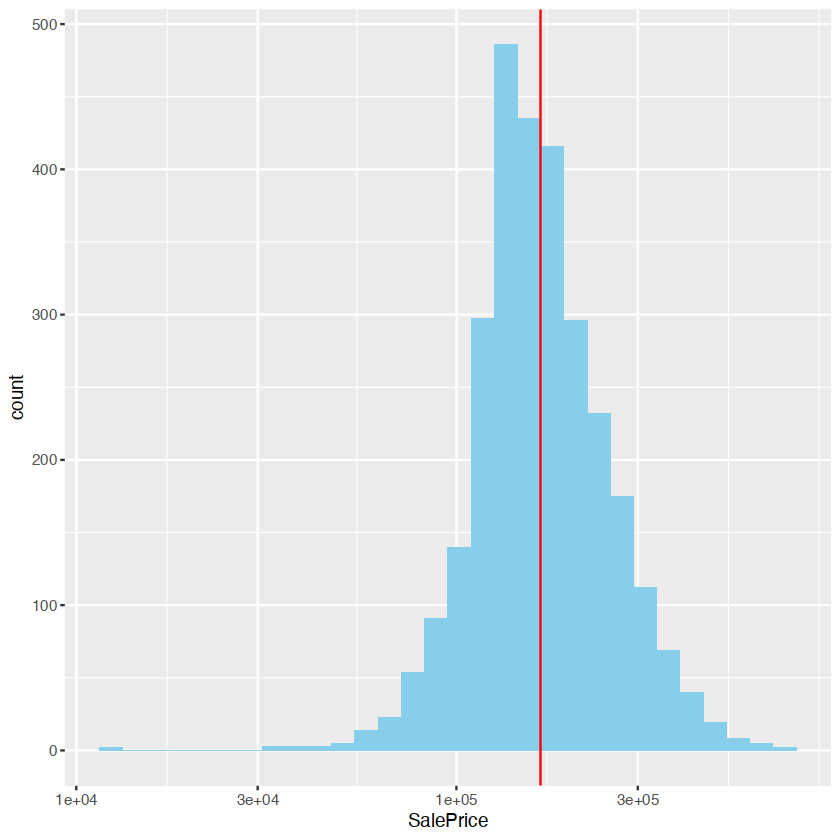

In [8]:
ggplot(ames_raw)+geom_histogram(fill="skyblue")+aes(x=SalePrice)+geom_vline(xintercept = exp(mean(log(ames_raw$SalePrice))),col="red")+scale_x_log10()

Fitting the same model on the log transformed outcome

In [9]:
lmfit_null_log<- lm(log(SalePrice)~1,ames_raw)
summary(lmfit_null_log)


Call:
lm(formula = log(SalePrice) ~ 1, data = ames_raw)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.56463 -0.24953 -0.03804  0.25042  1.51350 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.02097    0.00753    1596   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4076 on 2929 degrees of freedom


RMSE is

In [10]:
sqrt(mean((ames_raw$SalePrice-exp(predict(lmfit_null_log)))^2))

[1] 81195.11

Notice that the RMSE is actually bigger with log transformed model.
So should we not transform?  What do we get from the transformation?

Here is the prediction uncertainty overlayed on the histogram.

Warning message in predict.lm(lmfit_null, interval = "prediction"):
“predictions on current data refer to _future_ responses
”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


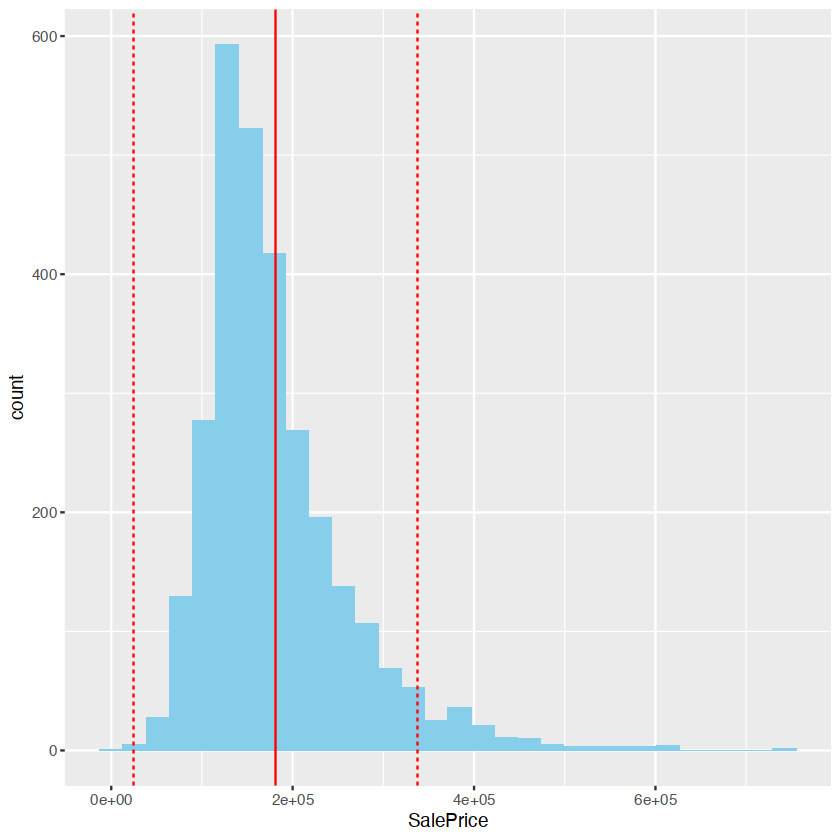

In [11]:
intpred=predict(lmfit_null,interval="prediction")
ggplot(ames_raw)+geom_histogram(fill="skyblue")+aes(x=SalePrice)+geom_vline(xintercept = mean(ames_raw$SalePrice),col="red")+geom_vline(xintercept = intpred[1,2],col="red",lty=2)+geom_vline(xintercept = intpred[1,3],col="red",lty=2)

Warning message in predict.lm(lmfit_null_log, interval = "prediction"):
“predictions on current data refer to _future_ responses
”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


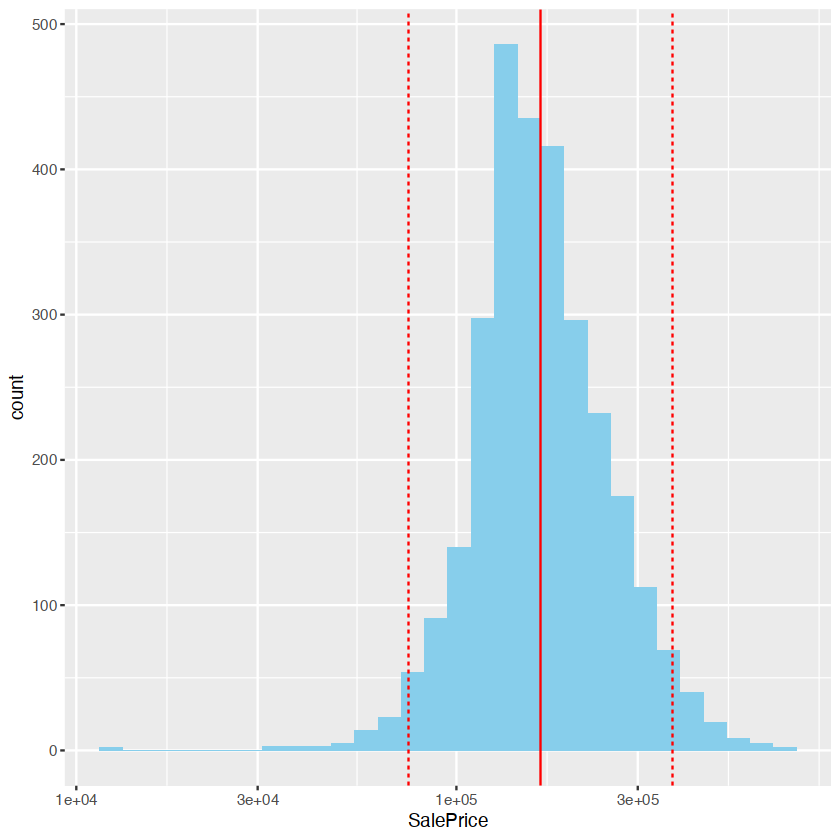

In [12]:
intpredlog=predict(lmfit_null_log,interval="prediction")
ggplot(ames_raw)+geom_histogram(fill="skyblue")+aes(x=SalePrice)+geom_vline(xintercept = exp(mean(log(ames_raw$SalePrice))),col="red")+scale_x_log10()+
  geom_vline(xintercept = exp(intpredlog[1,2]),col="red",lty=2)+
  geom_vline(xintercept = exp(intpredlog[1,3]),col="red",lty=2)

The log model seem to have a better uncertainty estimate.  What good does that do?

Let’s say the model is for an algorithm that buys the house.  If you pay more than the true price the company buys. If the price is lower, then the company fails to buy.
- If you bought for more than the true value you’ve over paid.
- If you bid less and lost, you lost a profit of the 10% of the house price.

Based on such loss function what is our overall loss if we base our decision on this model?

In [13]:
allres<-residuals(lmfit_null)
abs(sum(allres[allres<0]))+sum(0.1*(coef(lmfit_null)+allres[allres>0]))

[1] 114215680

In [14]:
allreslog<-ames_raw$SalePrice-exp(predict(lmfit_null_log))
abs(sum(allreslog[allreslog<0]))+sum(0.1*(exp(coef(lmfit_null_log))+allreslog[allreslog>0]))

[1] 94211655

As you can see with a better calibrated model you have a better performance for more realistic loss.

### Adding predictor `Gr Liv Area`

We add a predictor `Gr Liv Area`

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


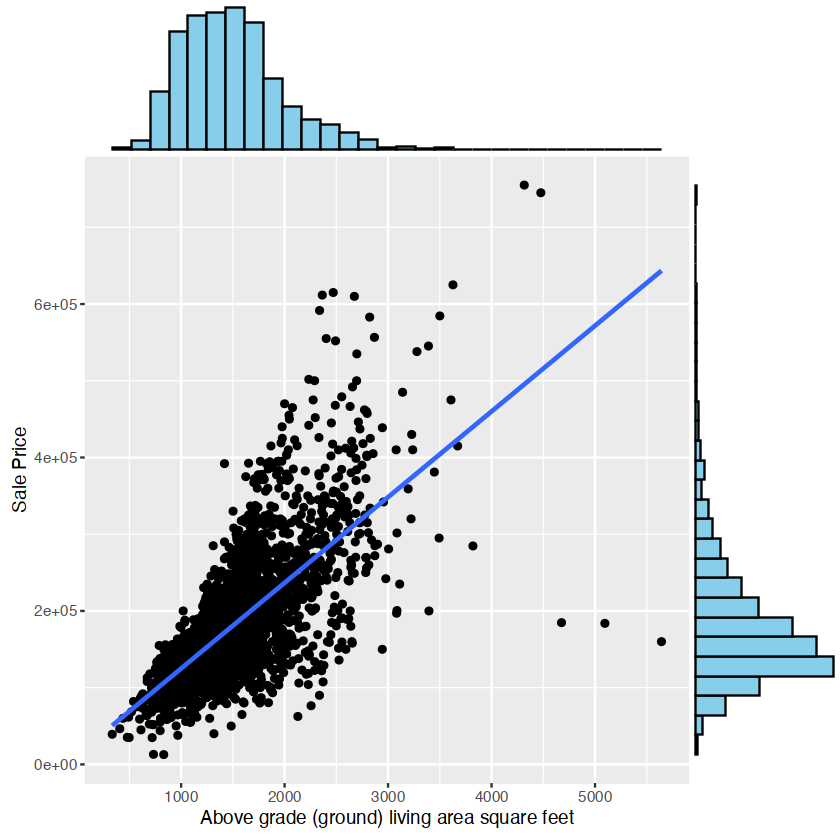

In [15]:
p=ggplot(ames_raw)+geom_point()+aes(x=`Gr Liv Area`,y=SalePrice)+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)
p3 <- ggMarginal(p, margins = 'both', fill="skyblue", size=4,type="histogram")
p3

Using `Gr Liv Area` as predictor

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `get()`:
! object 'rlm' of mode 'function' was not found”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `get()`:
! object 'rlm' of mode 'function' was not found”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `get()`:
! object 'rlm' of mode 'function' was not found”


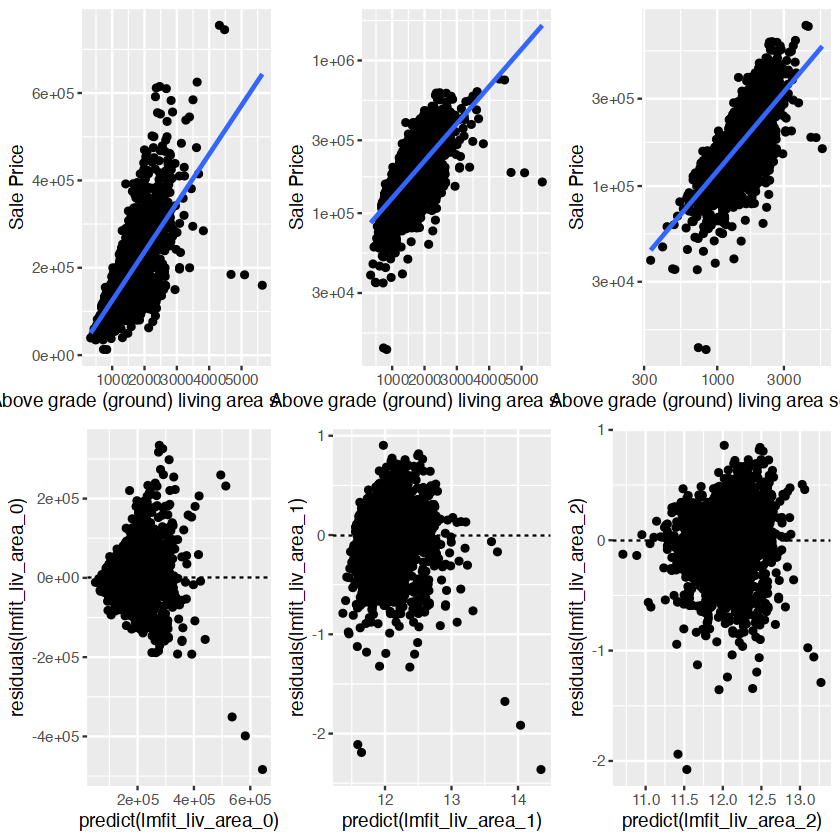

In [16]:
lmfit_liv_area_0<- lm(SalePrice~`Gr Liv Area`,ames_raw)
lmfit_liv_area_1<- lm(log(SalePrice)~`Gr Liv Area`,ames_raw)
lmfit_liv_area_2<- lm(log(SalePrice)~log(`Gr Liv Area`),ames_raw)
gridExtra::grid.arrange(
ggplot(ames_raw)+geom_point()+aes(x=`Gr Liv Area`,y=SalePrice)+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE),
ggplot(ames_raw)+geom_point()+aes(x=`Gr Liv Area`,y=SalePrice)+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)+scale_y_log10(),
ggplot(ames_raw)+geom_point()+aes(x=`Gr Liv Area`,y=SalePrice)+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)+scale_y_log10()+scale_x_log10(),
qplot(predict(lmfit_liv_area_0),residuals(lmfit_liv_area_0))+geom_smooth(method="rlm")+geom_hline(yintercept = 0,lty=2),
qplot(predict(lmfit_liv_area_1),residuals(lmfit_liv_area_1))+geom_smooth(method="rlm")+geom_hline(yintercept = 0,lty=2),
qplot(predict(lmfit_liv_area_2),residuals(lmfit_liv_area_2))+geom_smooth(method="rlm")+geom_hline(yintercept = 0,lty=2),
ncol=3
)

Because of the skewness it's better to take log on both x and y.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


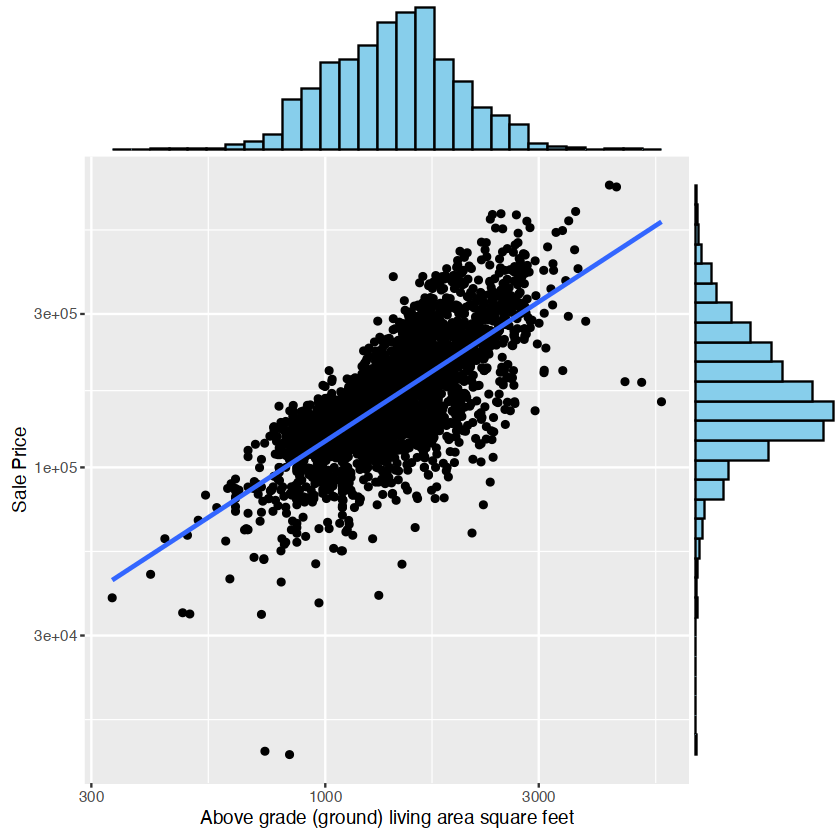

In [17]:
p=ggplot(ames_raw)+geom_point()+aes(x=`Gr Liv Area`,y=SalePrice)+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)+scale_y_log10()+scale_x_log10()
p3 <- ggMarginal(p, margins = 'both', fill="skyblue", size=4,type="histogram")
p3

In [18]:
lm_mod_1 <- lm(log(SalePrice)~log(`Gr Liv Area`),ames_raw)
summary(lm_mod_1)


Call:
lm(formula = log(SalePrice) ~ log(`Gr Liv Area`), data = ames_raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0778 -0.1465  0.0264  0.1740  0.8602 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         5.43019    0.11644   46.63   <2e-16 ***
log(`Gr Liv Area`)  0.90781    0.01602   56.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2816 on 2928 degrees of freedom
Multiple R-squared:  0.523,	Adjusted R-squared:  0.5228 
F-statistic:  3210 on 1 and 2928 DF,  p-value: < 2.2e-16


However, the residual still shows heterogeneous spread.

Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve




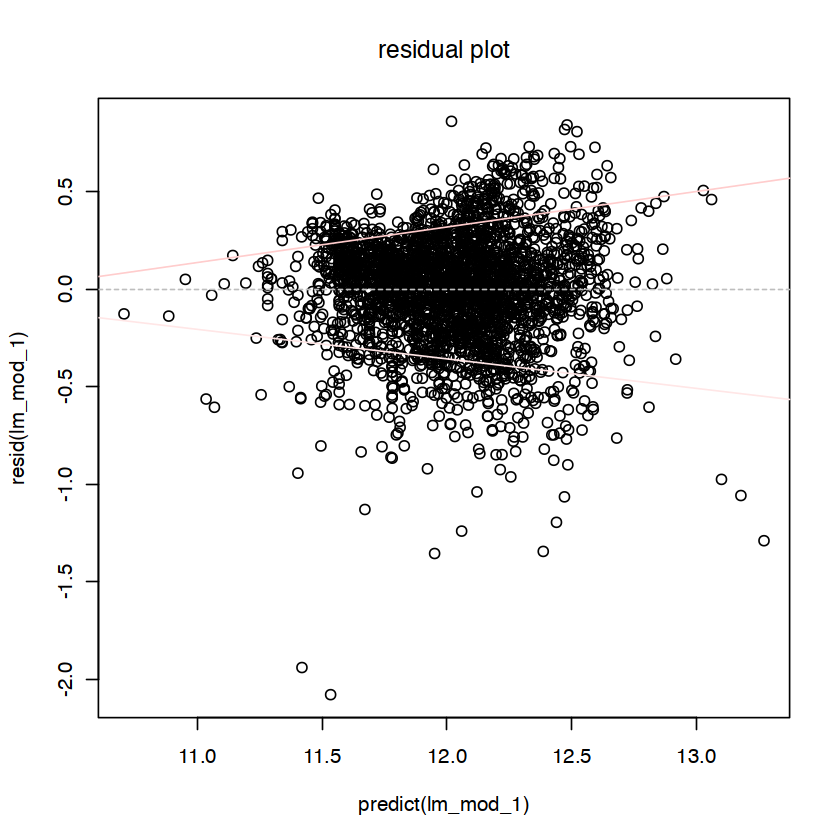

In [19]:
plot(predict(lm_mod_1),resid(lm_mod_1),main="residual plot");abline(h=0,lty=2,col="grey")
library(quantreg)
qu<-rq(resid(lm_mod_1)~predict(lm_mod_1),tau = c(0.1, 0.9))

colors <- c("#ffe6e6", "#ffcccc", "#ff9999", "#ff6666", "#ff3333",
            "#ff0000", "#cc0000", "#b30000", "#800000", "#4d0000", "#000000")
for (j in 1:ncol(qu$coefficients)) {
    abline(coef(qu)[, j], col = colors[j])
}

Did we reduce the residual variability?

No id variables; using all as measure variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
log(`Gr Liv Area`),1,254.4697,254.46966823,3209.97,0
Residuals,2928,232.1166,0.07927479,NA,NA


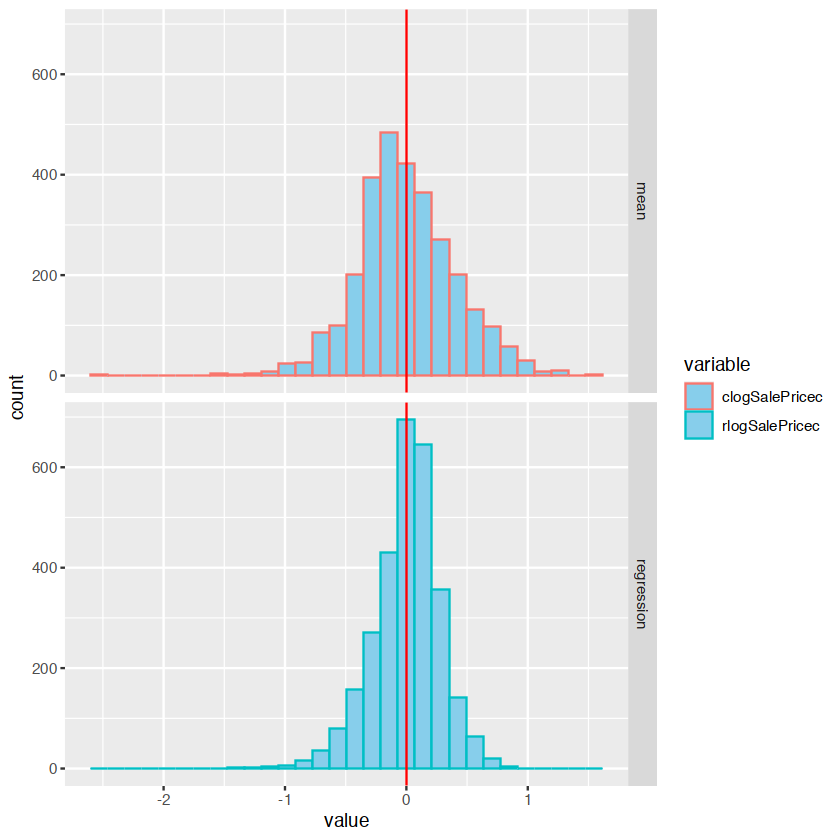

In [20]:
logSalePrice<-log(ames_raw$SalePrice)
clogSalePricec <-logSalePrice-mean(logSalePrice)
rlogSalePricec<-resid(lm_mod_1)
labs<-c("mean","regression")
names(labs)<-c("clogSalePricec","rlogSalePricec")
ggplot(melt(data.frame(clogSalePricec,rlogSalePricec)))+
  geom_histogram(fill="skyblue")+
  aes(x=value,color=variable)+geom_vline(xintercept = 0,col="red")+
  facet_grid(variable~.,labeller = labeller(variable = labs))
anova(lm_mod_1)

Looking at correlation with predictors.

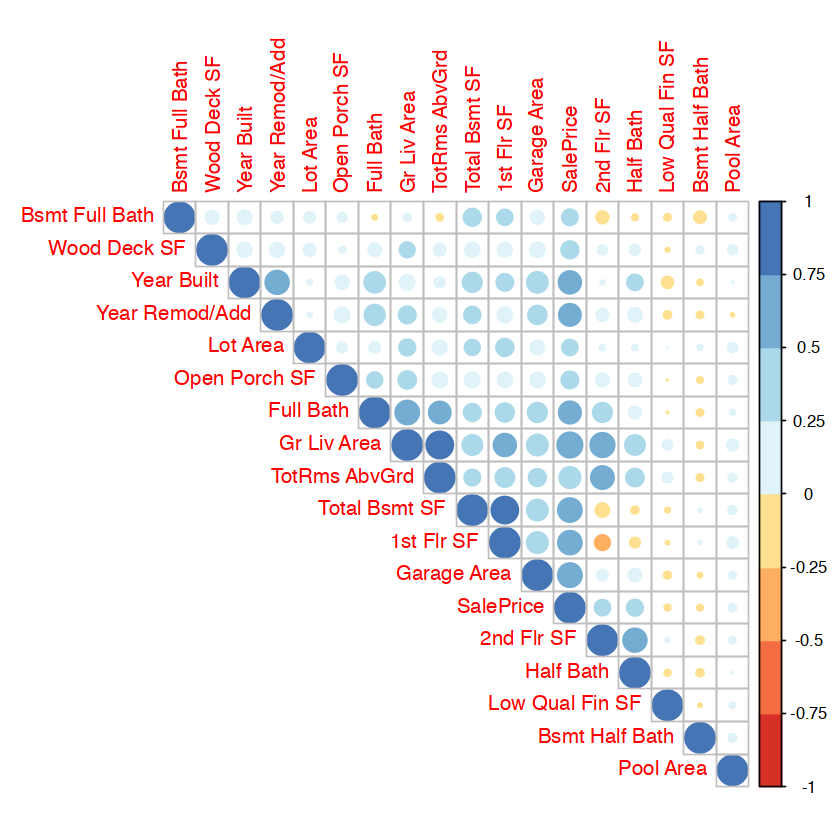

In [21]:
#`Lot Area`,`Year Built`,`Year Remod/Add`,`Total Bsmt SF`,`1st Flr SF`,`2nd Flr SF`,`Low Qual Fin SF`,`Gr Liv Area`,`Full Bath`,`Half Bath`,`Bsmt Full Bath`,`Bsmt Half Bath`,`TotRmsAbvGrd`,`Garage Area`,`Wood Deck SF`,`Open Porch SF`,`Pool Area`,`Sale Type`
M <-cor(ames_raw[,c("Lot Area","Year Built","Year Remod/Add","Total Bsmt SF","1st Flr SF","2nd Flr SF","Low Qual Fin SF","Gr Liv Area","Full Bath","Half Bath","Bsmt Full Bath","Bsmt Half Bath","TotRms AbvGrd","Garage Area","Wood Deck SF","Open Porch SF","Pool Area","SalePrice")],use="pairwise.complete.obs")
corrplot(M, type="upper", order="hclust",
         col=brewer.pal(n=8, name="RdYlBu"))


Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


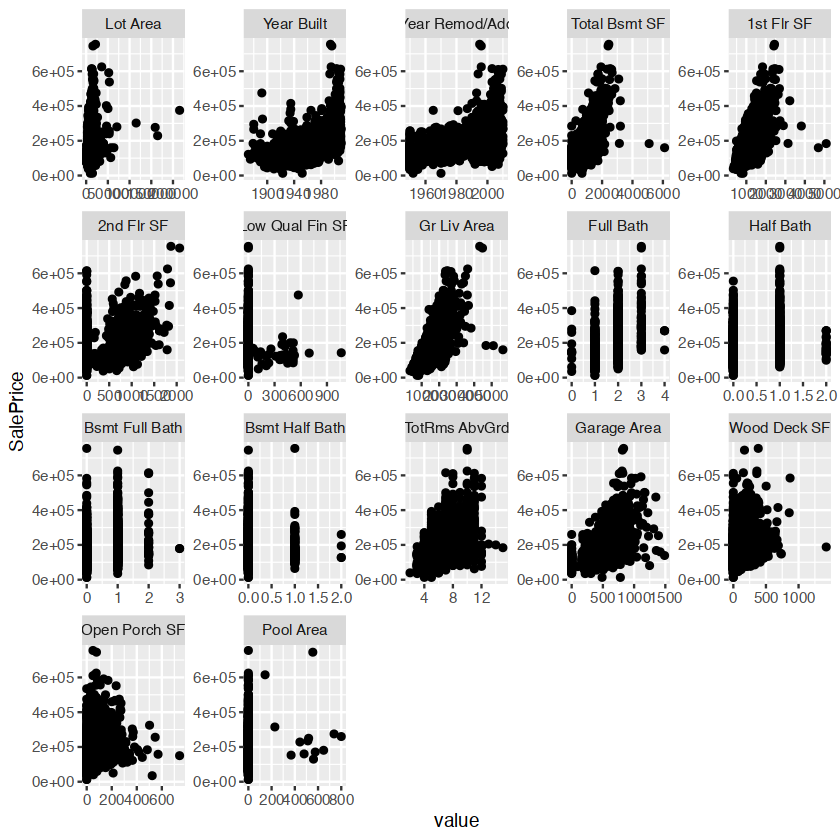

In [22]:
mames<-melt(ames_raw[,c("Lot Area","Year Built","Year Remod/Add","Total Bsmt SF","1st Flr SF","2nd Flr SF","Low Qual Fin SF","Gr Liv Area","Full Bath","Half Bath","Bsmt Full Bath","Bsmt Half Bath","TotRms AbvGrd","Garage Area","Wood Deck SF","Open Porch SF","Pool Area","SalePrice")],id.vars = "SalePrice")
ggplot(mames)+geom_point()+aes(x=value,y=SalePrice)+facet_wrap(variable~.,scales = "free")

### thinking about the `Lot Area`

When looking at lot area, its no surprise to have some relationship with the price.
But the relationship is not clear linear one.  Why?

`geom_smooth()` using formula = 'y ~ x'


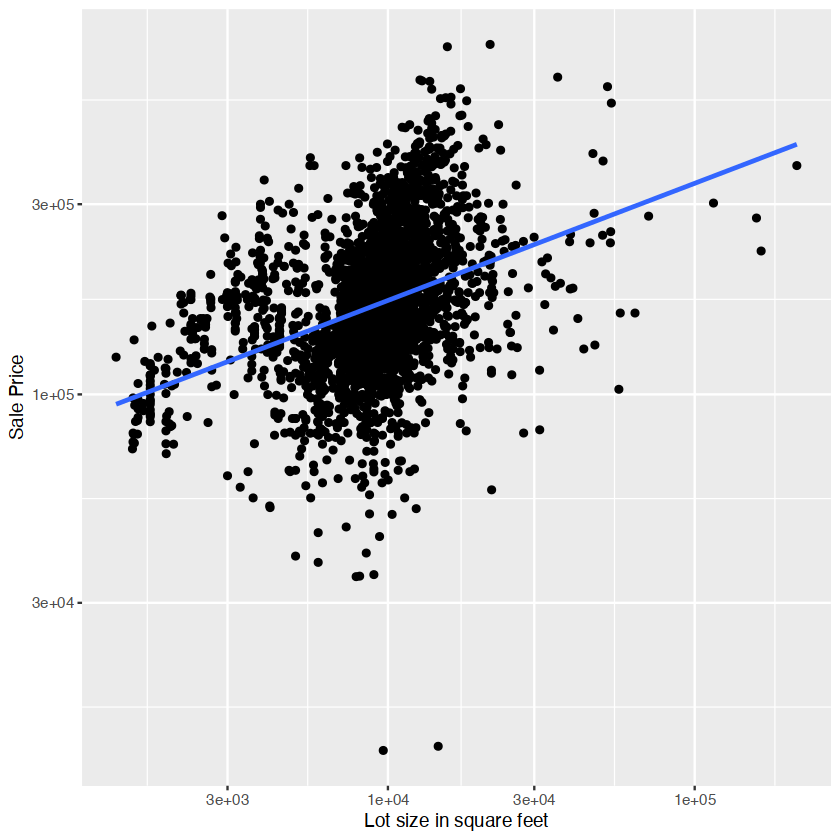

In [23]:
ggplot(ames_raw)+geom_point()+aes(x=`Lot Area`,y=SalePrice)+xlab("Lot size in square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)+scale_y_log10()+scale_x_log10()#+facet_grid(~`Bedroom AbvGr`)

If you look at this by the neighborhood it become obvious how in some places size matters more than others.

`geom_smooth()` using formula = 'y ~ x'


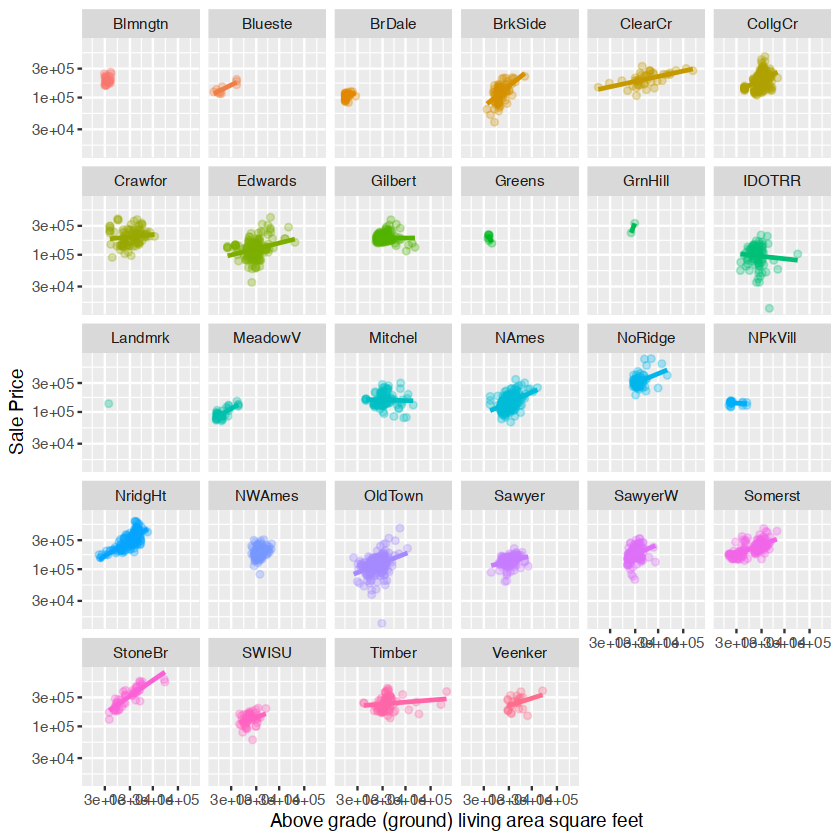

In [24]:
ggplot(ames_raw)+geom_point(alpha=0.3)+aes(x=`Lot Area`,y=SalePrice,color=factor(Neighborhood))+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)+scale_y_log10()+scale_x_log10()+ theme(legend.position = "none")+facet_wrap(~Neighborhood)

# sqrt(mean(residuals(lmfit_null)^2))
# intpred=predict(lmfit_null,interval="prediction")
# 
# allres<-residuals(lmfit_null)


### Considering Time

It seems the price is fairly stable over the years.

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


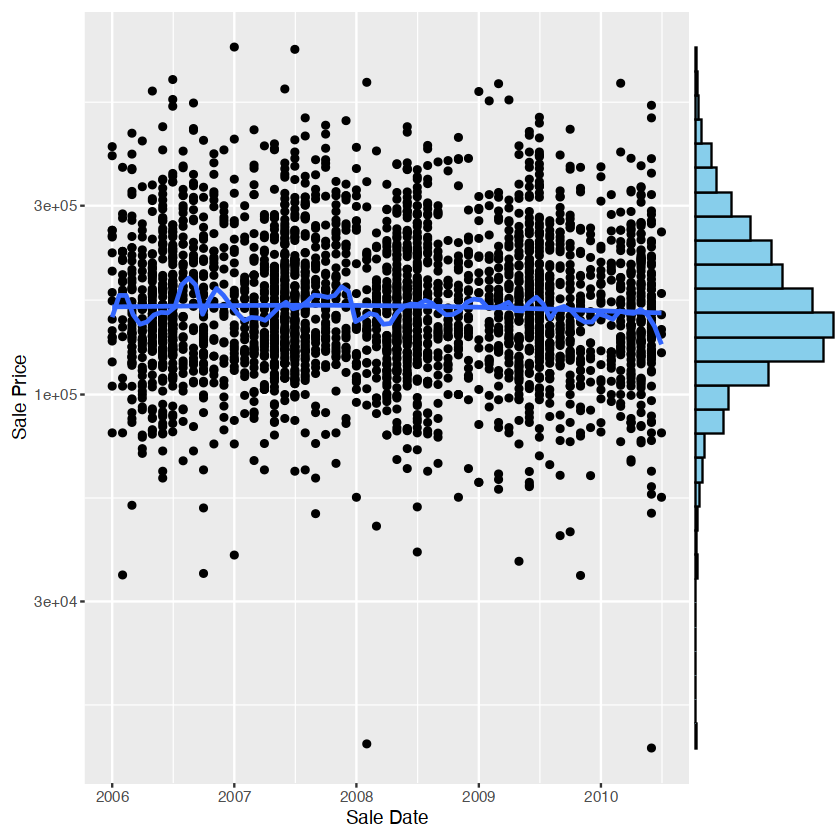

In [25]:
ames_raw$saledt <- ym(paste0(ames_raw$`Yr Sold`,"-",ames_raw$`Mo Sold`))

rolling_median <- function(formula, data, n_roll = 11, ...) {
  x <- data$x[order(data$x)]
  y <- data$y[order(data$x)]
  y <- zoo::rollmedian(y, n_roll, na.pad = TRUE)
  structure(list(x = x, y = y, f = approxfun(x, y)), class = "rollmed")
}

predict.rollmed <- function(mod, newdata, ...) {
  setNames(mod$f(newdata$x), newdata$x)
}
p=ggplot(ames_raw)+geom_point()+aes(x=saledt,y=SalePrice)+xlab("Sale Date")+ylab("Sale Price")+scale_y_log10()+geom_smooth(se=FALSE)+geom_smooth(formula = y ~ x, method = "rolling_median",se=FALSE)
p3 <- ggMarginal(p, margins = 'y', fill="skyblue", size=4,type="histogram")
p3

### Prediction of future based on data upto 2008

To make the project more realistic, I will split the data into before 2008 and after.
The data up to 2008 will be the training data nd after will be the testing data.

In [26]:
ames_raw_2008=ames_raw[ames_raw$`Yr Sold`<2008,]
ames_raw_2009=ames_raw[ames_raw$`Yr Sold`>=2008,]

Fitting the null model on the training data

In [27]:
lmfit_null_2008     <- lm(SalePrice~1,ames_raw_2008)
lmfit_null_log_2008 <- lm(log(SalePrice)~1,ames_raw_2008)

Comparing the MSE

In [28]:
sqrt(mean((ames_raw_2009$SalePrice-predict(lmfit_null,newdata=ames_raw_2009))^2))
sqrt(mean((ames_raw_2009$SalePrice-exp(predict(lmfit_null_log,newdata=ames_raw_2009)))^2))

[1] 77587.03

[1] 78531.29

Comparing the business loss

In [29]:
allres_2009=ames_raw_2009$SalePrice-predict(lmfit_null,newdata=ames_raw_2009)
abs(sum(allres_2009[allres_2009<0]))+sum(0.1*(coef(lmfit_null_2008)+allres_2009[allres_2009>0]))

allreslog_2009<-(ames_raw_2009$SalePrice-exp(predict(lmfit_null_log,newdata=ames_raw_2009)))
abs(sum(allreslog_2009[allreslog_2009<0]))+sum(0.1*(exp(coef(lmfit_null_log_2008))+allreslog_2009[allreslog_2009>0]))

[1] 63806382

[1] 52684502

### In class activity

Use data of `ames_raw` up to 2008 predict the housing price for the later years.

In [30]:
ames_raw_2008=ames_raw[ames_raw$`Yr Sold`<2008,]
ames_raw_2009=ames_raw[ames_raw$`Yr Sold`>=2008,]

Use the following loss function calculator.

In [31]:
calc_loss<-function(prediction,actual){
  difpred <- actual-prediction
  RMSE <-sqrt(mean(difpred^2))
  operation_loss<-abs(sum(difpred[difpred<0]))+sum(0.1*actual[difpred>0])
  return(
    list(RMSE,operation_loss
         )
  )
}

Here are few rules:
- You care not allowed to use the test data.
- You cannot use automatic variable selection.
- You need to explay why you added each variable.

In [32]:
lmfit_2008<- # ["your model here"] # use ames_raw_2008

ERROR: Error in parse(text = x, srcfile = src): <text>:2:0: unexpected end of input
1: lmfit_2008<- # ["your model here"] # use ames_raw_2008
   ^


When you decide on your model use the following to come up with your test loss.

In [33]:
pred_2009<-exp(predict(lmfit_2008,newdata=ames_raw_2009))
calc_loss(pred_2009,ames_raw_2009$SalePrice)

ERROR: Error in predict(lmfit_2008, newdata = ames_raw_2009): object 'lmfit_2008' not found


Try to answer the following additional questions.

- Does your model indicate a good fit?  If not where is the fit off?


Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



- Should you include all the predictors? Why?


Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



- What interaction makes sense?  Does your model indicate signs of interaction?


Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



- Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor, fit a model with polynomial terms up to 3rd order.


Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



## Problem Set
### [Problems] Linear Regression Problems

8. This question involves the use of simple linear regression on the `Auto` data set.
(a) Use the lm() function to perform a simple linear regression with mpg as the response and horsepower as the predictor. Use the summary() function to print the results.

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



Comment on the output.
For example:
i. Is there a relationship between the predictor and the response?

ii. How strong is the relationship between the predictor and the response?

iii. Is the relationship between the predictor and the response positive or negative?

iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95% confidence and prediction intervals?

(b) Plot the response and the predictor. Use the `abline()` function to display the least squares regression line.


Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



(c) Use the `plot()` function to produce diagnostic plots of the least squares regression fit. Comment on any problems you see with the fit.

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



9. This question involves the use of multiple linear regression on the `Auto` data set.

(a) Produce a scatterplot matrix which includes all of the variables in the data set.

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



(b) Compute the matrix of correlations between the variables using
the function cor(). You will need to exclude the name variable,
cor() which is qualitative.

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



(c) Use the lm() function to perform a multiple linear regression
with mpg as the response and all other variables except name as
the predictors. Use the summary() function to print the results.

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



Comment on the output. For instance:
i. Is there a relationship between the predictors and the response?
ii. Which predictors appear to have a statistically significant relationship to the response?

iii. What does the coefficient for the year variable suggest?

(d) Use the plot() function to produce diagnostic plots of the linear regression fit. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unusually high leverage?

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



(e) Use the * and : symbols to fit linear regression models with interaction effects. Why did you add the interaction?  Explain using the context of the problem.  Do any interactions appear to be statistically significant?  

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



(f) Try a few different transformations of the variables, such as $log(X)$, $\sqrt{X}$, $X^2$. Comment on your findings.


This question should be answered using the Carseats data set.
(a) Fit a multiple regression model to predict Sales using Price, Urban, and US.

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



(b) Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



(c) Write out the model in equation form, being careful to handle the qualitative variables properly.

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



(d) For which of the predictors can you reject the null hypothesis $H_0 :\beta_j = 0$?

Your answer:

In [ ]:
Please write your answer in full sentences.



(e) On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



(f) How well do the models in (a) and (e) fit the data?


Your answer:

In [ ]:
Please write your answer in full sentences.



(g) Using the model from (e), obtain 95% confidence intervals for the coefficient(s).

Your code:

In [ ]:
#
#

Your answer:

In [ ]:
Please write your answer in full sentences.



(h) Is there evidence of outliers or high leverage observations in the model from (e)?


Your answer:

In [ ]:
Please write your answer in full sentences.



## Additional Material

### K-nn regression

You can do KNN regression using FNN package.
Read more about it here:
https://daviddalpiaz.github.io/r4sl/knn-reg.html

In [ ]:
library(FNN)
knn.reg(train = ?, test = ?, y = ?, k = ?)

- train: the predictors of the training data
- test: the predictor values,  x, at which we would like to make predictions
- y: the response for the training data
- k: the number of neighbors to consider


### [Advanced] Predictive Modeling Platforms in R

There are few platforms in R that does predictive modeling.
These platforms are wrappers around other packages that makes it easy to do routine tasks.

- mlr3 (https://mlr3book.mlr-org.com)
- tidymodels (https://www.tidymodels.org/)
- caret (https://topepo.github.io/caret/)
- h2o (https://docs.h2o.ai/h2o/latest-stable/h2o-r/docs/index.html)

In [ ]:
# split the data
index <- sample(1:nrow(ames_raw), 0.7*nrow(ames_raw))
vars <- c("SalePrice","Lot Area","Gr Liv Area","Full Bath")
train <- ames_raw[ index, vars]
test  <- ames_raw[-index, vars]
colnames(train) <- make.names(colnames(train))
colnames(test)  <- make.names(colnames(test))

# mlr3 TaskRegr
train$SalePrice <- log(train$SalePrice)

#### Prediction using mlr3

MLR3 is a useful ML platform on R.
You can learn about it here:
https://mlr3book.mlr-org.com
There is MLR and MLR3.  It's better to use 3 since MLR is no longer actively developed.

In [ ]:
# load packages and data
library(mlr3)
library(mlr3learners)

# fit a model

task <- as_task_regr(train, target ="SalePrice",id = "ames_raw")

# TaskRegr$new(id = "ames_raw", backend = train, target ="SalePrice")
learner <- lrn("regr.lm", predict_type = "response")
learner$train(task)
prediction=predict(learner,newdata=test)

#### Prediction using [tidymodels](https://www.tidymodels.org/)

Tidymodels is another one of the tidy family that is similar to mlr3.
https://www.tidymodels.org/

In [ ]:
# load packages and data
library(tidymodels)
library(dotwhisker)
# fit a model
rec <- recipe(SalePrice ~ ., data = train) 

clf <- linear_reg() 

wflow <- workflow() %>%
         add_recipe(rec) %>%
         add_model(clf)

lm_fit <- wflow %>% fit(data = train)
prediction=predict(lm_fit,new_data=test)
tidy(lm_fit) %>% 
  dwplot(dot_args = list(size = 2, color = "black"),
         whisker_args = list(color = "black"),
         vline = geom_vline(xintercept = 0, colour = "grey50", linetype = 2))


#### Prediction using caret

In [ ]:
# load packages and data
library(caret)

# fit a model
ctrl <- trainControl(method = "none")
lm_model <- train(SalePrice ~ ., data = train, method = "lm", trControl = ctrl)

prediction=predict(lm_model,newdata = test)


#### Prediction using h2o

H2O is a cross platform library that is popular in the predictive modeling space.  They work well out of box and can be called from any platform independent of the language used.  Making it work on R could sometimes be a headache.  So try using H2O but if you cannot make it work, I recommend you leave this section alone.


If you are on Mac you will need to install Java (http://www.java.com ).

In [ ]:
install.packages("h2o")
# load packages and data
library(h2o)
packageVersion("h2o")

##### Starting H2O

To use H2O you need to instanciate it.

In [ ]:
# nthreads specifies number of threads. -1 means use all the CPU cores.
# max_mem_size specifies the maximum amount of RAM to use.
localH2O <- h2o.init(nthreads = -1, max_mem_size="4g")

You can access H2O instance using the web UI FLOW by typing 
 http://localhost:54321
 in your browser.

##### Serving the data to H2O

Since H2O is not in R, you need to tell it to use your data.

In [ ]:
train_hf <- as.h2o(train)
test_hf <- as.h2o(test)

##### Fitting GLM

In [ ]:
gaussian.fit = h2o.glm(y = "SalePrice",                               #response variable 
                       x = c("SalePrice","Lot.Area","Gr.Liv.Area","Full.Bath"),  #predictor variables
                      training_frame = train_hf,                  #data
                      family = "gaussian",lambda = 0)           #specify the dist. of y and penalty parameter: lambda
gaussian.fit

prediction=predict(gaussian.fit,newdata = test_hf)
h2o.exportFile(prediction, "/tmp/pred.csv", force = TRUE) #export prediction result as a file


##### Saving and loading the model

In [ ]:
# save the model
model_path <- h2o.saveModel(object=gaussian.fit, path=getwd(), force=TRUE)
print(model_path)

# load the model
saved_model <- h2o.loadModel(model_path)  #extract the saved model
saved_model